# Counting experiment 

This notebook aims to simulate a counting experiment for non interacting particles homogeneously distributed in space.

In [1]:
import random
import numpy as np
import statistics
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.fftpack import fft, fftfreq, ifft
from scipy.stats import pearsonr, ttest_ind
from statsmodels.graphics import tsaplots
import scipy.stats as st
import scipy as sp
from scipy.stats import poisson
import warnings
warnings.filterwarnings(action='ignore')

random.seed(10000)

## Content

1. Creating signal : random Poisson process 
2. FFT & Power spectrum 
 -  Analysis for a single run
 - Adding stadistics
3. Characterizing the spectrum 
4. Testing Null-Hypothesis
 - Parametric test
 - Non parametric test

## 1. Random Poisson Process 

In [2]:
def RPP(N_events,λ):
    '''This function generates a random poisson process. Imputs:
    The number of events to generate:     N_events
    Average constant rate           :      λ                 '''
    
    Event_num = []                    # Iteration
    Inter_event_times = []            # Inter times
    Event_times = []                  # Absolute time
    Event_time = 0                    # Starter

#_______________________________#GENERATE_TIME_INTERVALS#__________________________________#
   
    for i in range(N_events):      
        Event_num.append(i)
        p = random.random()
        Inter_event_time = -np.log(1.0 - p) / λ
        Event_time = Event_time + Inter_event_time
        Inter_event_times.append(Inter_event_time)
        Event_times.append(Event_time)
        
    Interval_nums = []
    Num_events_in_interval = []
    Interval_num = 1
    N_events = 0
    
#________________________________#GENERATE_TIME_EVENTS#____________________________________#   
    for i in range(len(Event_times)):
        Event_time = Event_times[i]
        if Event_time < Interval_num:
            N_events += 1
        else:
            Interval_nums.append(Interval_num)
            Num_events_in_interval.append(N_events)

            Interval_num += 1
            N_events =1 # This counter allows you to have zero detections when set to zero.
    return Interval_nums, Num_events_in_interval,Event_num

Some cross chekings...

In [3]:
#Check

N_events = 200
λ = 2.0
Homogeneous = RPP(N_events,λ)

In [4]:
# Number of events actually generated 

np.sum(Homogeneous[1])

199

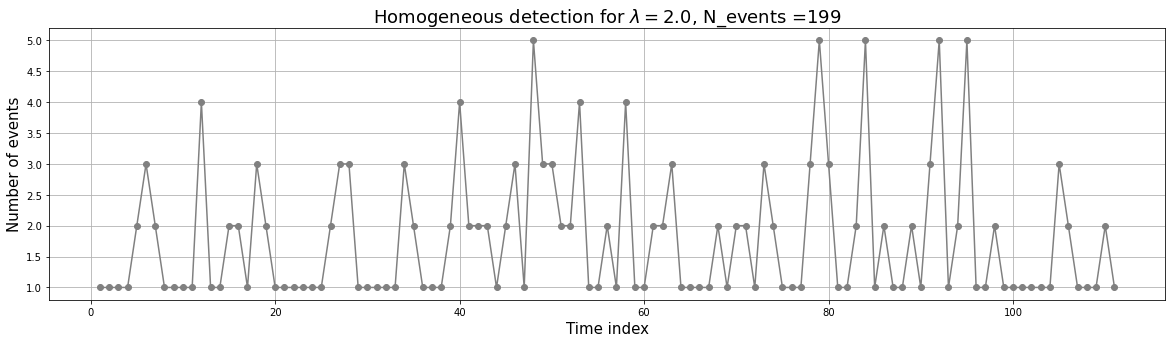

In [5]:
# "Signal index in time"

plt.figure(figsize= (20,5))
plt.plot(Homogeneous[0], Homogeneous[1], 'o-', color= "0.5")
plt.title('Homogeneous detection for $λ=$'+str(λ) + ', N_events ='+str(np.sum(Homogeneous[1])), size = 18)
plt.ylabel('Number of events', size=15)
plt.xlabel('Time index', size=15)
plt.grid()
#plt.savefig('Signal_1.0.jpg', format='jpg')

## 2. FFT & Power Spectrum 

### 2.1 Analysis for a single run

In [6]:
Ftime = len(Homogeneous[0])
freq = fftfreq(Ftime)                 # Creates all the necesary frequencies 
Imask = freq >= 0                     # Ignoring half the values , as they are complex conjugated of the other
mask = freq > 0                       # Ignoring also central peak

# Signal
signal = Homogeneous[1]

# Fourier transform
Fourier =fft(signal)

#Power Spectrum 
Power = 2.0*(np.abs(Fourier)/Ftime)**2.0 

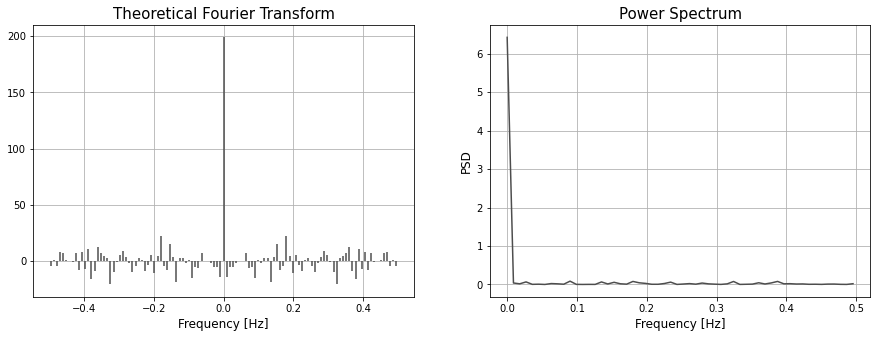

In [7]:
# Checking

fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].vlines(freq,0, Fourier, color = '0.3')
axs[0].set_xlabel('Frequency [Hz]', size=12)
axs[0].set_title('Theoretical Fourier Transform', size=15)
axs[0].grid()
axs[1].plot(freq[Imask], Power[Imask], color = '0.3')
axs[1].set_xlabel('Frequency [Hz]', size=12)
axs[1].set_ylabel('PSD', size=12)
axs[1].set_title('Power Spectrum', size=15)
axs[1].grid()

In [8]:
# Let's check if the power is going somewhere CROSSCHECK

mean_signal = np.mean(signal)
std_signal = np.std(signal)
var_signal = std_signal**2
Crosscheck = np.sum(Power[mask])

In [9]:
var_signal, Crosscheck

(1.1732813894976055, 1.1732813894976057)

### 2.2 Analysis for N samples: adding statistics 

In [10]:
def Stats(N, N_events,λ):
    '''This function generates N times the sample from the function RPP and ensures all of them have  equal lenth.
    The imputs of this function are the same as RPP plus the number of samples to generate: 
    N.     '''
    
    TimeSample =[]
    BackSample = []
    
    for i in range(N):
        Time, B ,numm = RPP(N_events,λ)
        TimeSample.append(Time)
        BackSample.append(B)
    
        
    Cut = len(min(TimeSample))
    Time_cut = [TimeSample[i][0:Cut] for i in range(N)]
    Back_cut = [BackSample[i][0:Cut] for i in range(N)]
    
    return Time_cut[0], Back_cut

In [11]:
#Checking 

N = 1000
N_events = 200
Sampling = Stats(N, N_events,λ)

In [12]:
# Checking lenths

Sampling[0][-1], len(Sampling[1][0])

(79, 79)

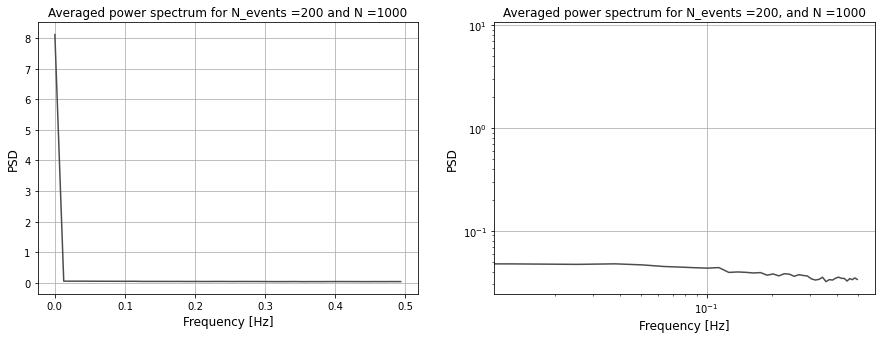

In [13]:
# Averaged Spectrum 

IHN_e= len(Sampling[0])
IHfreq = fftfreq(IHN_e)       
IHmask = IHfreq >= 0
mask = IHfreq > 0
SFourier =np.array([fft(Sampling[1][k]) for k in range(N)])
SignalPower =[2.0*np.abs(SFourier[k]/IHN_e)**2.0 for k in range(N)]
data1 = np.array(SignalPower).mean(axis=0) 

#Plot
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(IHfreq[IHmask], data1[IHmask], color = '0.3')
axs[0].set_title('Averaged power spectrum for N_events ='+str(N_events)+' and N ='+str(N), size=12)
axs[0].set_xlabel('Frequency [Hz]', size=12)
axs[0].set_ylabel('PSD', size=12)
axs[0].grid();
axs[1].loglog(IHfreq[IHmask], data1[IHmask], color = '0.3')
axs[1].set_title('Averaged power spectrum for N_events ='+str(N_events)+ ', and N ='+str(N), size=12)
axs[1].set_xlabel('Frequency [Hz]', size=12)
axs[1].set_ylabel('PSD', size=12)
axs[1].grid();

## 3. Characterizing Power Spectrum 

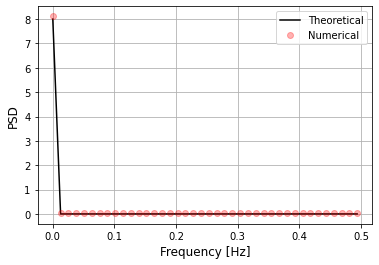

In [14]:

#Defining the delta function
def delta(λ,n):
    function = []
    for i in range(len(n)):
        if np.array(n[i]).any() == 0:
            function.append(4*λ)
        else:
            function.append(0)
    return function


plt.plot(IHfreq[IHmask] ,delta(λ, IHfreq[IHmask]), 'k' , label = 'Theoretical')
plt.plot(IHfreq[IHmask], data1[IHmask], 'ro', alpha=0.3, label = 'Numerical')
plt.xlabel('Frequency [Hz]', size=12)
plt.ylabel('PSD', size=12)
plt.legend()
plt.grid()

Comparing... Fast Tests

In [15]:
from scipy.stats import ttest_ind

# Two tail test 

stat, p = ttest_ind(delta(λ,IHfreq[IHmask]), data1[IHmask])

print((stat, p))

(-0.14061902441956564, 0.8885334302928991)


In [16]:
from scipy import stats
stats.mannwhitneyu(delta(λ, IHfreq[IHmask]),data1[IHmask], alternative='greater')


MannwhitneyuResult(statistic=39.0, pvalue=0.9999999999999967)

## 4. Testing Null Hypothesis 

The theoretical approach is going to be the baseline for further statistical testing. The average spectrum and the theoretical spectrum are compared for different time duration of the signals in order to prove consistency. 

$H_{0}:$ the power spectrum corresponds to gaussian white noise. \
$H_{1}:$ the power spectrum does not corresponds to gaussian white noise.

Is expected for this particular case  to be unable to reject the null hypothesis as time increases.

In [17]:
def time_trials( N,N_events, λ):
    '''This function generates average spectrums for differnt time lengths and compere the
    result with the theoretical white noise spectrum and with the power spectra generated 
    directly from poisson samples.'''
    
    T1_pvalue = []                             #store p-values from t-test 1.
    T2_pvalue = []                             #store p-values from t-test 2.
    MW1_pvalue = []                            #store p-values from Mann-whitney test 1.
    MW2_pvalue = []                            #store p-values from Mann-whitney test 2. 
    times = []                                 #store duration of signals
    
    for i in range(len(N_events)):
        time,back=Stats(N, N_events[i],λ)
        
        #Signal analysis 
        IHN_e= time[-1]
        IHfreq = fftfreq(IHN_e)       
        IHmask = IHfreq >= 0
        mask = IHfreq > 0
        SFourier =np.array([fft(back[k]) for k in range(N)])
        SignalPower =[2.0*np.abs(SFourier[k]/IHN_e)**2.0 for k in range(N)]
        data1 = np.array(SignalPower).mean(axis=0) 
        
        # Analythical 
        
        analytical = poisson.rvs(mu=λ, size= time[-1])
        IHN= len(analytical)
        Afreq = fftfreq(IHN)       
        Amask = Afreq >= 0
        AFourier = fft(analytical)
        APower =2.0*np.abs(AFourier/IHN)**2.0 
        
        # Theoretical 
        
        PowerT =delta(λ, IHfreq)
        
    
        statt1, pt1 = ttest_ind(APower[Amask], data1[IHmask])
        statt2, pt2 = ttest_ind(delta(λ,IHfreq[IHmask]), data1[IHmask])
        statm1, pm1 = stats.mannwhitneyu( APower[Amask], data1[IHmask], alternative='greater')
        statm2, pm2 = stats.mannwhitneyu(delta(λ, IHfreq[IHmask]), data1[IHmask], alternative='greater')
        
        T1_pvalue.append(pt1)
        T2_pvalue.append(pt2)
        MW1_pvalue.append(pm1)
        MW2_pvalue.append(pm2)
        times.append(IHN_e)
        
        
    return  T1_pvalue,T2_pvalue, MW1_pvalue, MW2_pvalue, times

In [20]:
N_events = list(range(100,1000, 200))
N = 10000
Testeando1 = time_trials( N, N_events,λ)

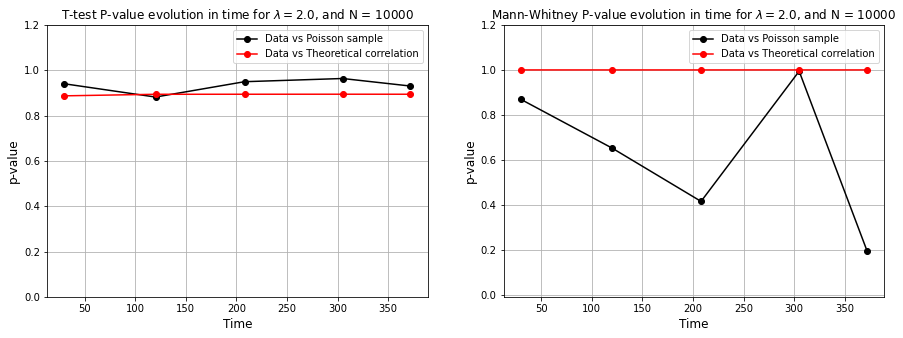

In [21]:
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(Testeando1[-1], Testeando1[0], 'ko-', label= 'Data vs Poisson sample')
axs[0].plot(Testeando1[-1], Testeando1[1], 'ro-', label = 'Data vs Theoretical correlation')
axs[0].set_ylim(0, 1.2)
axs[0].set_xlabel('Time', size= 12)
axs[0].set_ylabel('p-value',  size= 12)
axs[0].set_title('T-test P-value evolution in time for $λ=$'+str(λ)+', and N = '+str(N), size= 12)
axs[0].grid()
axs[0].legend()
axs[1].plot(Testeando1[-1], Testeando1[2], 'ko-', label= 'Data vs Poisson sample')
axs[1].plot(Testeando1[-1], Testeando1[3], 'ro-', label= 'Data vs Theoretical correlation')
axs[1].set_ylim(-0.01, 1.2)
axs[1].set_xlabel('Time', size= 12)
axs[1].set_ylabel('p-value',  size= 12)
axs[1].set_title('Mann-Whitney P-value evolution in time for $λ=$'+str(λ)+', and N = '+str(N), size= 12)
axs[1].grid()
axs[1].legend()